# Additional exercises to present

# Exercise 1 (optional) - fit a parabola to a datafile

On Moodle, you can find the file ```noisy_dataset.txt```, which contains the x and y data. Fit the function of the type ```ax^2 + b^x + c``` to the dataset using the embedded function ```np.linalg.lstsq``` to calculate the $\chi^2$ values. Plot the results. 


# Exercise 2 (Optional) - Simulating a planet's orbit with leapfrog and forward Euler alrorithms

Imagine that you have a planet orbiting a star. The acceleration of the planet is given by

${\bf a} = \frac{GM}{r^3}{\bf r}$, where $M$ is the mass of the star (you can assume the solar mass), $\bf r$ is the radius-vector, and $G$ is the gravitational constant. You can assume that the planet orbits at 1~au. Write a coupled set of equations for radius and velocity and then: 

**(A)** Simulate 10 years of the planet's motion using the leapfrog algorithm. 

**(B)** Simulate 10 years of the planet's motion using the forward Euler algorithm. 

**(C)** Plot the evolution of the radius, the angular momentum, and the total energy for both algorithms. Discuss your results. Which algorithm is a better fit for this task?

Forward Euler:

$
v(t+dt) = v(t) + a(t) dt
$

$
r(t+dt) = r(t) + v(t) dt
$

Leapfrog:

$
v(t+dt/2) = v(t) + a(t) dt/2
$

$
r(t+dt)   = r(t) + v(t+dt/2) dt
$

$
v(t+dt)   = v(t+dt/2) + a(t+dt) dt/2
$

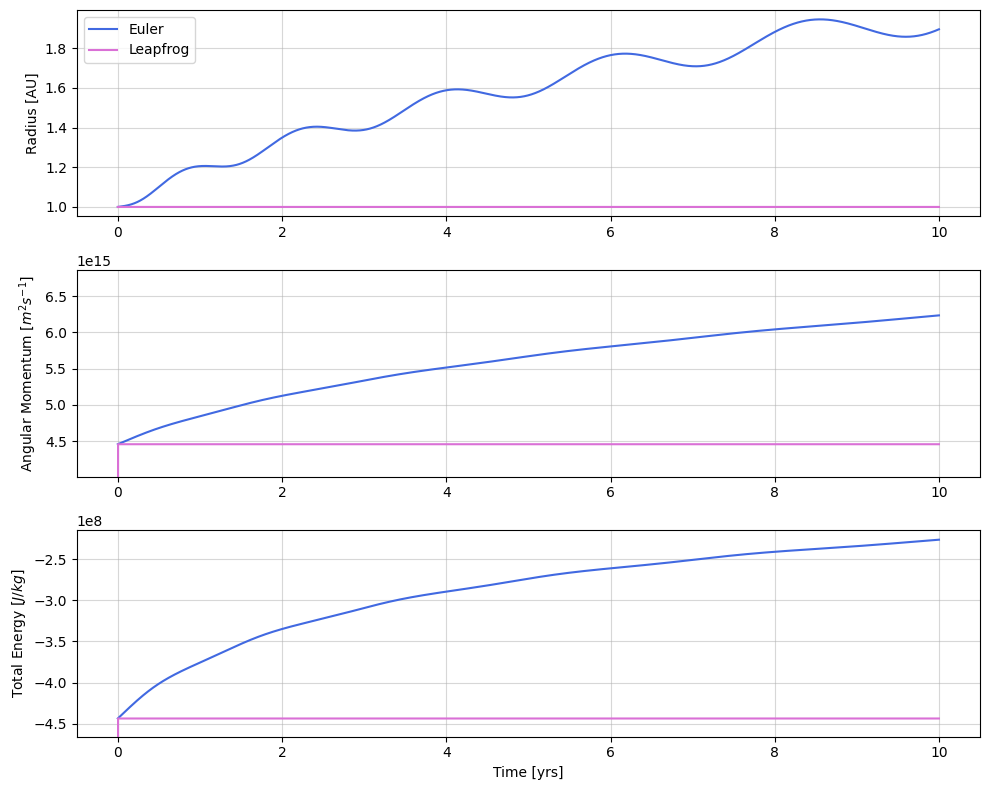

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
G = 6.67430e-11       # Gravitational constant (m^3 kg^-1 s^-2)
M = 1.989e30          # Mass of the Sun (kg)
AU = 1.496e11         # Astronomical Unit (meters)
YEAR = 365.25 * 24 * 3600 # One Earth year in seconds

def acceleration(r):
    """
    Calculates the gravitational acceleration vector exerted by the Sun
    on a body at position r.

    The formula used is a = -GM * r / |r|^3, derived from Newton's Law of Gravitation.
    The acceleration is always directed towards the origin (0,0).

    Parameters:
    r (np.array): A 2D vector [x, y] representing the position of the planet.

    Returns:
    np.array: A 2D vector [ax, ay] representing the acceleration components.
    """
    dist = np.linalg.norm(r)
    # Avoid division by zero 
    if dist == 0:
        return np.array([0.0, 0.0])
    return -G * M * r / dist**3

def get_energy(r, v):
    """
    Calculates the specific total mechanical energy (per unit mass) of the orbit.

    Total Energy = Kinetic Energy + Potential Energy
    E = (1/2)v^2 - GM/r

    This is a conserved quantity in a closed 2-body system. 
    If the integration method is perfect, this value should remain constant over time.

    Parameters:
    r (np.array): Array of shape (N, 2) containing position vectors.
    v (np.array): Array of shape (N, 2) containing velocity vectors.

    Returns:
    np.array: A 1D array of specific energy values (Joules/kg).
    """
    speed_sq = np.linalg.norm(v, axis=1)**2
    kinetic = 0.5 * speed_sq
    potential = -G * M / np.linalg.norm(r, axis=1)
    return kinetic + potential

def get_angular_momentum(r, v):
    """
    Calculates the specific angular momentum (per unit mass) of the orbit.

    In 2D, the magnitude of angular momentum L = r x v = x*vy - y*vx.
    This quantity is also conserved for a central force like gravity.

    Parameters:
    r (np.array): Array of shape (N, 2) containing position vectors.
    v (np.array): Array of shape (N, 2) containing velocity vectors.

    Returns:
    np.array: A 1D array of angular momentum values (m^2/s).
    """
    return r[:, 0] * v[:, 1] - r[:, 1] * v[:, 0]

# Simulation Setup

# Simulation parameters
dt = 24 * 3600        # Time step: 1 day in seconds
T = 10 * YEAR        # Total simulation time: 10 years
steps = int(T / dt)  # Number of time steps

# Initial conditions (Circular orbit)
# Start at 1 AU on the x-axis
r0 = np.array([AU, 0.0])
# Velocity required for a circular orbit: v = sqrt(GM / r)
# Directed along the y-axis
v0 = np.array([0.0, np.sqrt(G * M / AU)])

# Forward Euler Integration
# A first-order method. It is simple but introduces significant error (energy drift) over time.
r_e = np.zeros((steps, 2))
v_e = np.zeros((steps, 2))
r_e[0] = r0
v_e[0] = v0

for i in range(steps - 1):
    a = acceleration(r_e[i])
    v_e[i+1] = v_e[i] + a * dt
    r_e[i+1] = r_e[i] + v_e[i] * dt


#Leapfrog Integration
# A second-order symplectic integrator. It is much better at conserving energy over long periods.
r_l = np.zeros((steps, 2))
v_l = np.zeros((steps, 2))
r_l[0] = r0
# Initialize the velocity at the "half-step" (t = dt/2)
v_half = v0 + 0.5 * acceleration(r0) * dt 

for i in range(steps - 1):
    # 1. Drift: Move position by full step using half-step velocity
    r_l[i+1] = r_l[i] + v_half * dt
    
    # 2. Kick: Update velocity by full step using new acceleration
    a_new = acceleration(r_l[i+1])
    v_half += a_new * dt
    
    # Store the synchronized velocity (at the same time level as r) for plotting
    v_l[i+1] = v_half - 0.5 * a_new * dt


# Diagnostics & Plotting

time_yrs = np.linspace(0, T/YEAR, steps)

# Calculate metrics for both methods
radius_e = np.linalg.norm(r_e, axis=1)
radius_l = np.linalg.norm(r_l, axis=1)
energy_e = get_energy(r_e, v_e)
energy_l = get_energy(r_l, v_l)
L_e = get_angular_momentum(r_e, v_e)
L_l = get_angular_momentum(r_l, v_l)

plt.figure(figsize=(10, 8))

# Plot 1: Radius
plt.subplot(3, 1, 1)
plt.plot(time_yrs, radius_e / AU, color="royalblue", label="Euler")
plt.plot(time_yrs, radius_l / AU, color="orchid", label="Leapfrog")
plt.ylabel("Radius [AU]")
plt.legend()
plt.grid(alpha=0.5)

# Plot 2: Angular Momentum
plt.subplot(3, 1, 2)
plt.plot(time_yrs, L_e, color="royalblue", label="Euler")
plt.plot(time_yrs, L_l, color="orchid", label="Leapfrog")
if np.min(L_e) > 0:
    plt.ylim(0.9*np.min(L_e), 1.1*np.max(L_e))
plt.ylabel("Angular Momentum [$m^{2}s^{-1}$]")
plt.grid(alpha=0.5)

# Plot 3: Total Energy
plt.subplot(3, 1, 3)
plt.plot(time_yrs, energy_e, color="royalblue", label="Euler")
plt.plot(time_yrs, energy_l, color="orchid", label="Leapfrog")

# Set appropriate y-limits for negative values
min_e = np.min(energy_e)
max_e = np.max(energy_e)
plt.ylim(min_e * 1.05, max_e * 0.95)

# Ensure axis is not inverted
ax = plt.gca()
if ax.yaxis_inverted():
    ax.invert_yaxis()

plt.ylabel("Total Energy [$J/kg$]")
plt.xlabel("Time [yrs]")
plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()

Leapfrog is the better algorithm. 

The Forward Euler method gains artificial energy over time, causing the orbit to spiral outward and the planet to escape. The Leapfrog method is stable and symplectic; it conserves energy and angular momentum effectively, keeping the orbit in a stable circle. 
   
